# RSA signatures

Sigurjón Ágústsson

In [13]:
import random
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [14]:
def load_small_primes():
    pfile =  open("1000primes.txt", "r")
    small_primes = [int(num) for num in pfile.read().split(',')]
    return small_primes

small_odd_primes = load_small_primes()
print(f"{len(small_odd_primes)} small odd primes loaded : {small_odd_primes[:5]}...{small_odd_primes[-3:]}")

999 small odd primes loaded : [3, 5, 7, 11, 13]...[7901, 7907, 7919]


In [96]:
def std_form(n):
    string_n = str(n)
    num = string_n[0] + "." + string_n[1:3] + f"*10^{len(string_n)-1}"
    return num

    


In [15]:
math.ceil(math.log(401)/math.log(2))

9

In [16]:
a = 0b1010
a.bit_length()

4

In [17]:
for i in range(a.bit_length()):
    bit = (a&(1<<(a.bit_length()-1-i)))>>(a.bit_length()-1-i)
    print(f"b_{i} is:", bit)

b_0 is: 1
b_1 is: 0
b_2 is: 1
b_3 is: 0


We start by introducing some helper functions. Most important of which is the modular exponentiation function which uses Montgomery modular multiplication to very quickly compute modular exponentiation.

In [18]:
def even(n):
    """Checks the parity of n"""
    return (n&1) != 1

def pow_n_mod_n(a,n):
    """Naive and very inefficient way of doing modular exponentiation"""
    return ((a**(n-1)) % n)

def modular_exponentiation_old(a,n):
    """Python's fast way of doing modular exponentiation"""
    """Returns a**(n-1) mod n"""
    return pow(a,(n-1),n)

def modular_exponentiation(a,N):
    """Python's fast way of doing modular exponentiation"""
    """Returns a**(N-1) mod N"""
    return exp_powering_with_reductions(a,(n-1), N)

def extended_euclidiean(a,b):
    r = [a,b]
    s = [1,0]
    t = [0,1]
    i = 2
    while True:
        q_im1 = r[-2] // r[-1]
        r_i = r[-2] - q_im1 * r[-1]
        s_i = s[-2] - q_im1 * s[-1]
        t_i = t[-2] - q_im1 * t[-1]
        
        if r_i == 0:
            u,v = s[-1],t[-1]
            break
        r.append(r_i)
        s.append(s_i)
        t.append(t_i)
    return u, v

def exp_powering(a,b,n):
    """Returns a**b mod n"""
    number = 1
    while b:
        if b & 1:
            number = number * a % n
        b >>= 1
        a = a * a % n
    return number

def montgomery(a, R, N):
    """Returns the montgomery form of the integer a with respect to N"""
    return (a*R) % N



def mmult(a,b,N):
    pass


def divisible_by_small_prime(n, resolution=1000):
    """A function that checks if a number n has one of the 
        1000 first primes as a factor (excluding 2 because 
        it is checked for already)"""
    global small_odd_primes # The array of primes
    for small_prime in small_odd_primes[:resolution]:
        if n == small_prime:
            # In this case n is a small prime number, and we return
            # False to indicate it is not divisible by any of
            # the smaller primes
            return False
        if (n % small_prime) == 0:
            # print("diviseble by small prime")
            return True
    return False

def seconds_to_prefix(sec):
    """Just a function that inputs number of seconds (float) and 
        outputs a string representation with a unit (s, ms or min) """
    if sec < 1:
        ms = sec * 1000
        return "{} ms".format(round(ms,4))
    elif sec < 60:
        return "{} s".format(round(sec,4))
    else:
        min = int(sec) // 60
        rem = seconds_to_prefix(sec-60*min)
        return "{} min and {}".format(min,rem)

In [19]:
def gcd(a,b):
    r = a%b
    if r==0:
        return b
    return gcd(b,r)

In [21]:
a,b,N = 5,7, 13
R = pow(2,math.ceil(math.log(N)/math.log(2))) # R is the smallest power of 2 that is 
u,v = extended_euclidiean(R,N)
Rp = u+N
Np = R-v
print(f"R is: {R}\nR' is: {Rp}\nN is: {N}\nN' is: {Np}\n")
print("R*Rp - N*Np")
print(f"({R}*{Rp}) - ({N}*{Np}) = {R*Rp - N*Np}\n")
print("R*Rp + N*Np")
print(f"({R}*{Rp}) + ({N}*{Np}) = {R*Rp + N*Np}\n")
print("minus: ", R*Rp - N*Np)
print("plus: ", R*Rp + N*Np)

if (R*Rp - N*Np) != 1:
    print("not right")
else:
    print("works!")

R is: 16
R' is: 9
N is: 13
N' is: 11

R*Rp - N*Np
(16*9) - (13*11) = 1

R*Rp + N*Np
(16*9) + (13*11) = 287

minus:  1
plus:  287
works!


In [22]:
a,b,N = 5,7, 13
print("a,b,N=", a,b,N)
print(f"normal: {exp_powering(a,b,N)}\nwith reductions: {exp_powering_with_reductions(a,b,N)}")
a,b,N = 5,91, 131
print("a,b,N=", a,b,N)
print(f"normal: {exp_powering(a,b,N)}\nwith reductions: {exp_powering_with_reductions(a,b,N)}")
      

a,b,N= 5 7 13
normal: 8
with reductions: 8
a,b,N= 5 91 131
normal: 53
with reductions: 53


In [23]:
f, t = 0,0
for _ in range(100):
    a = random.randint(25,50)
    n = random.randint(3, a)
    if not (n&1):
        continue
    assert exp_powering_with_reductions(a, (n-1), n) == exp_powering(a, (n-1), n) == modular_exponentiation_old(a,n) == modular_exponentiation(a,n), f"Failed for values a={a} n={n}"
    
print("successful")
print(f"subtraction performed {f} times \nNot perfomred {t} times")

successful
subtraction performed 0 times 
Not perfomred 0 times


Let's demonstrate with a timing example.

In [24]:
bits = 20
# Let n be a random 20 bit integer
n_odd = True
while n_odd:
    n = random.randint((1<<(bits-1)),((1<<bits)-1))
    if n&1:
        break
a = random.randint(0xFFFF,n-1) # a very large number but still less than n


ex1_start = time.perf_counter()
print(pow_n_mod_n(a,n))
ex1_end = time.perf_counter()
ex2_start = time.perf_counter()
# print(modular_exponentiation_(a,n))
print(exp_powering_with_reductions(a, n-1, n))
ex2_end = time.perf_counter()
t1,t2 = (ex1_end-ex1_start), (ex2_end-ex2_start)
strt1,strt2 = seconds_to_prefix(t1), seconds_to_prefix(t2)
diff = round(t1/t2,2)
print("Using the slow algorithm, it took: {} \
        \nUsing the fast algorithm, it took: {}".format(strt1,strt2))
print("The Montgomery algorithm makes modular exponentiation {} times faster in this case!".format(diff))

132643
132643
Using the slow algorithm, it took: 2.4532 s         
Using the fast algorithm, it took: 0.0819 ms
The Montgomery algorithm makes modular exponentiation 29953.72 times faster in this case!


## Prime number generation

Now we are ready to do generate prime numbers. 

In [25]:
def probable_prime(size):
    assert size > 0
    s = size-1
    smallest = 1<<s
    largest = (1<<(s+1))-1
    while True:
        # First pick a random number n of size 'size' bits
        n = random.randint(smallest,largest)
        if even(n) or divisible_by_small_prime(n):
            continue
        a = random.randint(2,n-1)

#         mod_computation = modular_exponentiation_old(a,n)
        mod_computation = exp_powering_with_reductions(a,(n-1),n)

        if mod_computation == 1:
            # By Fermat's little thm, if the result is not 1
            # then n is not prime, otherwise, it is likely to 
            # be prime
            return n

Let's use this to generate some "small" probably-prime numbers, or pseudoprimes.

In [26]:
for i in range(4):
    bits = 8*(i+1)
    print("{} bits: \t".format(bits), probable_prime(bits))

8 bits: 	 193
16 bits: 	 63419
24 bits: 	 16520797
32 bits: 	 2875123021


In RSA encryption we want much larger primes. Typically 1024 or 3072 bits. That is no obstacle for us, let's generate such pseudoprimes:

In [27]:
t1s = time.perf_counter()
p1024 = probable_prime(1024)
t1e = time.perf_counter()
print(p1024)
print("execution time: {} seconds".format(round((t1e-t1s),3)))

158771352697281701929497229332633053068313288514189715528258283356267213574945243855021726543746895331929651713449864789473590846736969461767525117400525637983818353627537167397378776826174394670972487184586440558499645849467597802768002672267303013362439264628857870805777449592733449062351880326921681883693
execution time: 0.565 seconds


In [28]:
t1s = time.perf_counter()
p3072 = probable_prime(2048)
t1e = time.perf_counter()
print(p3072)
print("execution time: {} seconds".format(round((t1e-t1s),3)))

18889316897202585214334338348257169173156034517398571751764813355614939930796399896915765365182227957884129041035686612753556596867819417572966047848410508496242204400984048074449809402877939582022718474958559516669335405168442129100820850549110854337682814942211086869601354650787888546651393936328429273243779227579220061357568362641454573555907043101220028586291234165135845173937493101022869527087121812275711874809915391643926378076913389191286553266039646518940313716190801304584480386753400562615038248586479501356121614807027998560642248361952796068260135447414089711101488689962164976524214180273575867674409
execution time: 4.221 seconds


## RSA signatures

In [29]:
e = 3
print(pow(e,-1,500))

167


In [30]:
def find_ed(N,T):
    e = 3
    d = pow(e,-1,T)
    return (e,d)

In [118]:
def generate_keys(size=512):
    """Function that returns a tuple of public and private keys of given size (in bits)"""
    p,q = probable_prime(size),probable_prime(size)
    N = p*q
    # e is less than T. And it is coprime to T and N
    # e*d mod T has to be 1
    # e is typically 3
    T = N - p - q + 1 # (p-1)(q-1)
    e = 3
    d = exp_powering_with_reductions(e,-1,T)
#     d = pow(e,-1,T)
    return ((N,e),(N,d))


def encrypt(val, public_key):
    """public key is a tuple containing N,e """
    N,e = public_key
    return exp_powering_with_reductions(val,e,N)
#     return pow(val,e,N)

def decrypt(cipher, private_key):
    """Private key is a tuple containing N,d """
    N,d = private_key
    return exp_powering_with_reductions(cipher, d,N)
    return pow(cipher,d,N)

In [119]:
while True:
    try:
        public_key, secret_key = generate_keys()
        break
    except:
        continue
# public_key, secret_key = dummy_keys()

R: 1.34*10^154, N: 1.04*10^154
res_bar=T greater than N
R=1.34*10^154 and N=1.04*10^154
R larger
REDC t is: 8.64*10^307 >> 512 ->  False
t:  6.44*10^153
N:  1.04*10^154
R: 1.34*10^154, N: 1.11*10^154
res_bar=T greater than N
R=1.34*10^154 and N=1.11*10^154
R larger
REDC t is: 5.79*10^307 >> 512 ->  False
t:  4.31*10^153
N:  1.11*10^154
R: 1.34*10^154, N: 6.88*10^153
res_bar=T greater than N
R=1.34*10^154 and N=6.88*10^153
R larger
REDC t is: 2.48*10^307 >> 512 ->  False
t:  1.85*10^153
N:  6.88*10^153
R: 1.34*10^154, N: 1.08*10^154
res_bar=T greater than N
R=1.34*10^154 and N=1.08*10^154
R larger
REDC t is: 8.42*10^307 >> 512 ->  False
t:  6.28*10^153
N:  1.08*10^154
R: 1.34*10^154, N: 9.02*10^153
res_bar=T greater than N
R=1.34*10^154 and N=9.02*10^153
R larger
REDC t is: 6.96*10^307 >> 512 ->  False
t:  5.19*10^153
N:  9.02*10^153
R: 1.34*10^154, N: 7.11*10^153
res_bar=T greater than N
R=1.34*10^154 and N=7.11*10^153
R larger
REDC t is: 8.41*10^307 >> 512 ->  False
t:  6.27*10^153
N:

In [33]:
public_key

(118673765448352650596116826231080053557673490222755487044198917740682311206472416438550681717202081850551695843111905142583936871571700190873598260771460999365456772898800068851693815555939343210717942288021273818537399303804486415013898632486868693309373565911329073904442831418287897762093029655562254305421,
 3)

In [34]:
secret_key

(118673765448352650596116826231080053557673490222755487044198917740682311206472416438550681717202081850551695843111905142583936871571700190873598260771460999365456772898800068851693815555939343210717942288021273818537399303804486415013898632486868693309373565911329073904442831418287897762093029655562254305421,
 79115843632235100397411217487386702371782326815170324696132611827121540804314944292367121144801387900367797228741270095055957914381133460582398840514307318224687212428888705255855514582586028375706083469616800760308708638140110833211597006950251966967244332029898256016897545063355470472761066959569343538795)

In [39]:
text = "HELLO WORLD!"

In [40]:
def str2ascii_list(string):
    return [ord(c) for c in string]

def ascii_list2str(alist):
    s = ""
    for c in alist:
        s+=chr(c)
    return s

def encrypt_string(string, public_key):
    ascii_list = [ord(i) for i in string]
    enc_list = [encrypt(j,public_key) for j in ascii_list]
    print(enc_list)
    enc_string  = ""
    for enc in enc_list:
        enc_string += chr(enc)
    return enc_list

def decrypt_string(enc_list,private_key):
    ascii_list = [decrypt(j, private_key) for j in enc_list]
    return ascii_list

In [41]:
text_asc = str2ascii_list(text)
print("original:")
print(text_asc)
print("encrypted:")
enc = [encrypt(c, public_key) for c in text_asc]
print(enc)
print("decrypted_list")
dec_list = [decrypt(c, secret_key) for c in enc]
print(dec_list)
print("result")
res = ascii_list2str(dec_list)
print(res)

original:
[72, 69, 76, 76, 79, 32, 87, 79, 82, 76, 68, 33]
encrypted:
[373248, 328509, 438976, 438976, 493039, 32768, 658503, 493039, 551368, 438976, 314432, 35937]
decrypted_list
[72, 69, 76, 76, 79, 32, 87, 79, 82, 76, 68, 33]
result
HELLO WORLD!


In [42]:
# ASCII has values from 32 to 126
# print("Public,private keys are: ", public_key, secret_key)
for i in range(32,127):
    enc = encrypt(i, public_key)
    dec = decrypt(enc, secret_key)
    if dec == i:
        print(f"{i}, ASCII: '{chr(i)}', Encryption: '{enc}', Decrypting encryption: '{dec}'")
    else:
        print(f"{i}, ASCII: '{chr(i)}', Encryption: '{enc}', Decrypting encryption: '{dec}' - FAIL")

32, ASCII: ' ', Encryption: '32768', Decrypting encryption: '32'
33, ASCII: '!', Encryption: '35937', Decrypting encryption: '33'
34, ASCII: '"', Encryption: '39304', Decrypting encryption: '34'
35, ASCII: '#', Encryption: '42875', Decrypting encryption: '35'
36, ASCII: '$', Encryption: '46656', Decrypting encryption: '36'
37, ASCII: '%', Encryption: '50653', Decrypting encryption: '37'
38, ASCII: '&', Encryption: '54872', Decrypting encryption: '38'
39, ASCII: ''', Encryption: '59319', Decrypting encryption: '39'
40, ASCII: '(', Encryption: '64000', Decrypting encryption: '40'
41, ASCII: ')', Encryption: '68921', Decrypting encryption: '41'
42, ASCII: '*', Encryption: '74088', Decrypting encryption: '42'
43, ASCII: '+', Encryption: '79507', Decrypting encryption: '43'
44, ASCII: ',', Encryption: '85184', Decrypting encryption: '44'
45, ASCII: '-', Encryption: '91125', Decrypting encryption: '45'
46, ASCII: '.', Encryption: '97336', Decrypting encryption: '46'
47, ASCII: '/', Encryptio

In [43]:
encrypted = encrypt_string(text,public_key)
print(encrypted)
decrypted = decrypt_string(encrypted,secret_key)
print(decrypted)

[373248, 328509, 438976, 438976, 493039, 32768, 658503, 493039, 551368, 438976, 314432, 35937]
[373248, 328509, 438976, 438976, 493039, 32768, 658503, 493039, 551368, 438976, 314432, 35937]
[72, 69, 76, 76, 79, 32, 87, 79, 82, 76, 68, 33]


Different way to encode strings

In [44]:
def string_to_num(string):
    num = 0
    for c in string:
        new_char = ord(c)
        num = (num<<7)+new_char
    return num

def num_to_string(num):
    string = ""
    while num>0:
        new_char = 0x7F
        new_char &= num # Now new_char is the ascii value of the last character of the string
        string = chr(new_char) + string # We prepend the new character to the string, since we are going in the reverse
        num = num >> 7
    return string

s = "AB"

string_to_num(s)


8386

In [45]:
while True:
    try:
        public_key, private_key = generate_keys(100) # generate keys of size 100
        break
    except:
        continue
num_chars = 5
bits = num_chars * 8
largest, lowest = (1<<bits)-1, (1<<(bits-1))
for _ in range(5):
    num = random.randint(lowest,largest)
    s = num_to_string(num)
    e = encrypt(num, public_key)
    d = decrypt(e, private_key)
    ds = num_to_string(d)
    p  = f"{num} = {s} \t ---> {e} \t ---> {d} = {ds}"
    print(p)


810743745226 = L _J 	 ---> 532906258311159359751839034520403176 	 ---> 810743745226 = L _J
625262326840 = $'h8 	 ---> 244448168312497714536761563789504000 	 ---> 625262326840 = $'h8
957081884127 = m4+_ 	 ---> 876692492738119943730382407859156383 	 ---> 957081884127 = m4+_
=fM
988205589136 = a-E 	 ---> 965032451092474747375966484492947456 	 ---> 988205589136 = a-E


In [46]:
def rand_string(length):
    bits = length * 8
    largest, lowest = (1<<bits)-1, (1<<(bits-1))
    assert largest.bit_length() == bits
    num = random.randint(lowest,largest)
    s = num_to_string(num)
    return s
def rand_legible_string(length):
    bits = length * 8
    s = ""
    for _ in range(length):
        s += chr(random.randint(32,126))
    return s


In [47]:
while True:
    try:
        pkey, skey = generate_keys(50)
        break
    except:
        continue
pkey,skey

((949426674839794229043716759809, 3),
 (949426674839794229043716759809, 632951116559861517445798403811))

In [48]:
data = np.array([])
for _ in range(1000):
    data = np.append(data, rand_legible_string(10))
print(data[:5])
print(len(data))


['[UQ+E]|ke7' '%Dv< Qj;H6' 'gm.~=@l<jI' 'xH2y.=BU~g' '4{@~`WDI6%']
1000


In [49]:
word = rand_legible_string(10)
word_code = string_to_num(word)
print("legible string: ", word)
print("encoded: ", word_code)

legible string:  SHC}a&J29+
encoded:  770766296575621504171


In [50]:
locked = encrypt(word_code,pkey)
print(locked)

781314026087662416515156731751


In [51]:
unlocked = decrypt(locked,skey)
print(unlocked)

770766296575621504171


In [52]:
primitive_data = np.array([])

In [53]:
base = (1<<32)-1
print(bin(base))
for i in range(5):
    if i >0 :
        num = (1<<(8*i))-1
        shift = 32-8*i
    else:
        num = 1
        shift = 31
    num = num<<shift
    print(bin(num), len(bin(num))-2)

0b11111111111111111111111111111111
0b10000000000000000000000000000000 32
0b11111111000000000000000000000000 32
0b11111111111111110000000000000000 32
0b11111111111111111111111100000000 32
0b11111111111111111111111111111111 32


In [54]:
def generate_simple_data(bit_length):
    data = []
    for i in range(bit_length//8 +1):
        if i > 0 :
            num = (1<<(8*i))-1
            shift = bit_length-8*i
        else:
            num = 1
            shift = bit_length-1
        num = num<<shift
        data.append((num, bit_length-shift))
    return data

In [55]:
data = generate_simple_data(128)
len(data)

17

In [56]:
test = []
for num,size in data:
    tstart = time.perf_counter()
    decrypt(num,skey)
    tend = time.perf_counter()
    res = tend-tstart
    arr = [size, res]
#     print(arr)
    test.append(arr)
#     test[size] = tend-tstart

In [57]:
results = np.array(test)
x_values = results[:,0]
y_values = results[:,1]
results[:5]

array([[1.000e+00, 1.693e-04],
       [8.000e+00, 1.664e-04],
       [1.600e+01, 1.744e-04],
       [2.400e+01, 2.167e-04],
       [3.200e+01, 2.339e-04]])

In [58]:
dataframe = pd.DataFrame(results)
dataframe

0         1
0     1.0  0.000169
1     8.0  0.000166
2    16.0  0.000174
3    24.0  0.000217
4    32.0  0.000234
5    40.0  0.000162
6    48.0  0.000159
7    56.0  0.000158
8    64.0  0.000151
9    72.0  0.000167
10   80.0  0.000170
11   88.0  0.000170
12   96.0  0.000171
13  104.0  0.000169
14  112.0  0.000149
15  120.0  0.000150
16  128.0  0.000148

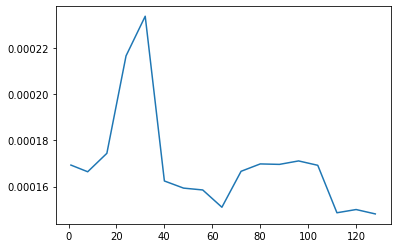

In [59]:
plt.plot(x_values, y_values)

In [60]:
seconds_to_prefix(results[0][1])

'0.1693 ms'

In [108]:
messages = [string_to_num(rand_legible_string(10)) for _ in range(10000)]
print(messages[:3])
print(pkey, skey)

[501295376811561630814, 589522065863462541942, 829305368049028441397]
(949426674839794229043716759809, 3) (949426674839794229043716759809, 632951116559861517445798403811)


Remember public key is $N, e$

In [122]:
def exp_powering_with_reductions(a,b,N):
    """Returns a**b mod n"""
    # First we choose R, it should be a power of two ! works only for odd N!
    if not N&1:
        print("warning N is even")
    pwr_of_R = math.ceil(math.log(N)/math.log(2))
    # Then we precompute R',N'
    u,v = extended_euclidiean(R,N)
    Rp,Np = u+N, R-v
    res_bar = montgomery(1,R,N)
    a_bar = montgomery(a,R,N)
    # we assume b = b_0b_1...b_{k-1}. we want to iterate over all bits
    for i in range(b.bit_length()):
        b_i = (b&(1<<(b.bit_length()-1-i)))>>(b.bit_length()-1-i)
        res_bar = res_bar * res_bar
        res_bar = REDC(res_bar, R,Rp, N,Np, pwr_of_R)
        if b_i:
            res_bar = res_bar * a_bar
            res_bar = REDC(res_bar, R,Rp, N,Np, pwr_of_R)
            first = False
    res = montgomery(res_bar, Rp, N)
    return res    

def REDC(T, R,Rp,N,Np,pwr_of_R):
    # T is res_bar
    m = ((T % R)*Np) % R
    t = (T + m*N)>>pwr_of_R
    if t>=N:
        return t-N
    else: 
        return t



In [123]:
# We want to create two sets of random variables. One where the first bit is
M1, M2 = [],[]
N, d = skey
for m in messages[:10]:
#     print("message: ", str(m)[:3]+"...")
    val = exp_powering_with_reductions(m, d, N)
    if oracle(m,N):
        M1.append(m)
    else:
        M2.append(m)
print(f"M1 has {len(M1)} messages")
print(f"M2 has {len(M2)} messages")

M1 has 0 messages
M2 has 10 messages


In [166]:
M = [i for i in range(2**4)]
pkey_candidate, skey_candidate = generate_keys(4)
pair1, pair2 = None, None
while True:
    if secret_key_b10
    public_key_b10, secret_key_b10 = generate_keys(4)
    public_key_b11, secret_key_b11 = generate_keys(4)
    if pair1 is not None and pair2 is not None:
        break
print("public key: ", public_key)
print("secret_key:", secret_key)
print(f"All values: [{M[0]}, {M[1]}, ..., {M[-1]}]")
print(f"  = [{bin(M[0])}, {bin(M[1])}, ..., {bin(M[-1])}]")

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N 

warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is even
warning N is even
0
warning N is

KeyboardInterrupt: 

In [140]:
# def oracle(a,b,N):
def oracle(M, N):
    """decides whether the first reduction of (a**b) is computed with a subtraction or not"""
    pwr_of_R = math.ceil(math.log(N)/math.log(2))
    R = pow(2,pwr_of_R) # R is the smallest power of 2 that is 
    # Then we precompute R',N'
    u,v = extended_euclidiean(R,N)
    Rp,Np = u+N, R-v
    res_bar = montgomery(1,R,N)
    a_bar = montgomery(M,R,N)
    b_1 = ... # we are trying to deduce this bit!
    res_bar = res_bar * res_bar
    res_bar = REDC(res_bar, R,Rp, N,Np, pwr_of_R)
    # if b_1 is 1 then this part will be executed
    res_bar = res_bar * a_bar
    # will a reduction occur after this step??
#     res_bar = REDC(res_bar, R,Rp, N,Np, pwr_of_R)
    T = res_bar
    # T in [0, RN − 1]
    assert 0<=T<= R*N -1
    print(f"0<= {std_form(T)} <= RN-1={std_form(R*N-1)}")
    m = ((T % R)*Np) % R
#     print(f"t is: {(T + m*N)} >> {pwr_of_R}")
    t = (T + m*N)>>pwr_of_R
    if t>=N: return True
    return False

In [164]:
M1, M2 = [],[]
N, d = skey
print("b_1 is: ", bin(d)[3])
print(bin(d))
for m in M:
#     print("message: ", str(m)[:3]+"...")
    val = exp_powering_with_reductions(m, d, N)
    if oracle(m,N):
        M1.append(m)
    else:
        M2.append(m)
print(f"M1 has {len(M1)} messages")
print(f"M2 has {len(M2)} messages")

b_1 is:  1
0b111111111010010110011100100011011101001000011111110010001101001111010100111011110011001111011100011
0<= 0.*10^0 <= RN-1=1.20*10^60
0<= 1.01*10^59 <= RN-1=1.20*10^60
0<= 2.02*10^59 <= RN-1=1.20*10^60
0<= 1.66*10^57 <= RN-1=1.20*10^60
0<= 1.02*10^59 <= RN-1=1.20*10^60
0<= 2.04*10^59 <= RN-1=1.20*10^60
0<= 3.33*10^57 <= RN-1=1.20*10^60
0<= 1.04*10^59 <= RN-1=1.20*10^60
0<= 2.05*10^59 <= RN-1=1.20*10^60
0<= 5.00*10^57 <= RN-1=1.20*10^60
0<= 1.06*10^59 <= RN-1=1.20*10^60
0<= 2.07*10^59 <= RN-1=1.20*10^60
0<= 6.67*10^57 <= RN-1=1.20*10^60
0<= 1.07*10^59 <= RN-1=1.20*10^60
0<= 2.09*10^59 <= RN-1=1.20*10^60
0<= 8.34*10^57 <= RN-1=1.20*10^60
M1 has 0 messages
M2 has 16 messages
